In [ ]:
import sys
!{sys.executable} -m pip install yfinance --user


In [3]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib --user


Looking in links: /usr/share/pip-wheels


In [137]:
"""
# Hybrid Kelly Criterion Trading Strategy
This Jupyter Notebook implements a dynamic position-sizing strategy using the Kelly Criterion.
It:
1. Fetches stock data using `yfinance`
2. Detects market regimes (Trending vs. Mean-Reverting)
3. Dynamically adjusts the Kelly Fraction based on volatility
4. Implements a basic backtesting framework
5. Applies different trading strategies for each market regime
6. Compares results to a buy-and-hold control strategy
7. Computes key performance metrics: Sharpe Ratio, Max Drawdown, and CAGR
8. Visualizes bankroll growth over time
9. Optimizes stock selection by focusing on high-growth stocks where Kelly performs best
10. Implements portfolio allocation across multiple high-growth stocks to compare Kelly vs. Buy & Hold
11. Refines hyperparameter tuning by including both successful and unsuccessful high-growth stocks for more realistic testing
12. Runs the final backtest using optimized parameters with proper data alignment
"""

# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import random

# Define a list of stocks that were considered high-growth five years ago
high_growth_stocks = [
    "AAPL", "MSFT", "TSLA", "AMZN", "GOOGL", "META", "NFLX", "SHOP", "ADBE",
    "SQ", "CRWD", "ZM", "ROKU", "PYPL", "ETSY", "DOCU", "SE", "TWLO"
]

# Function to fetch stock data with error handling
def get_stock_data(ticker, period="5y"):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period)
    if data.empty or len(data) < 1250:  # Ensure at least 5 years of daily data
        return None
    data["Returns"] = data["Close"].pct_change()
    return data

# Filter out stocks with no available data
def filter_valid_stocks(stock_list):
    return [ticker for ticker in stock_list if get_stock_data(ticker) is not None]

# Select 10 random stocks from the valid high-growth stock list
test_stocks = random.sample(filter_valid_stocks(high_growth_stocks), 10)

# Function to determine market regime
def detect_market_regime(data, short_window=20, long_window=50):
    data["Short_MA"] = data["Close"].rolling(window=short_window).mean()
    data["Long_MA"] = data["Close"].rolling(window=long_window).mean()
    data["Regime"] = np.where(data["Short_MA"] > data["Long_MA"], "Trending", "Mean Reversion")
    return data

# Function to compute Kelly Fraction
def compute_kelly_fraction(data):
    mean_return = data["Returns"].mean()
    variance = data["Returns"].var()
    base_kelly = mean_return / variance if variance != 0 else 0
    data["Kelly_Fraction"] = np.where(
        data["Regime"] == "Trending", base_kelly * 1.5,
        np.where(data["Regime"] == "Mean Reversion", base_kelly * 0.9, base_kelly)
    )
    return data

# Function to execute portfolio-based buy-and-hold strategy
def portfolio_buy_and_hold(stocks, initial_capital=1000):
    capital_per_stock = initial_capital / len(stocks)
    portfolio_bankroll = []
    dates_list = []

    for ticker in stocks:
        stock_data = get_stock_data(ticker)
        if stock_data is None or "Close" not in stock_data:
            continue  # Skip stocks with missing data

        # Implement Buy & Hold strategy
        stock_data["Buy_Hold_Bankroll"] = (stock_data["Close"] / stock_data["Close"].iloc[0]) * capital_per_stock
        
        if len(stock_data) > 0:
            dates_list.append(stock_data.index)
            portfolio_bankroll.append(stock_data["Buy_Hold_Bankroll"].values)

    # Ensure all bankroll arrays are the same length
    min_len = min(map(len, portfolio_bankroll))
    portfolio_bankroll = [bankroll[:min_len] for bankroll in portfolio_bankroll]

    # Align dates as well
    dates = dates_list[0][:min_len]

    # Compute total portfolio value across all stocks
    portfolio_bankroll = np.sum(np.array(portfolio_bankroll), axis=0)

    return dates, portfolio_bankroll


# Function to align portfolio lengths
def align_portfolio_lengths(dates, kelly_values, buy_hold_values):
    min_len = min(len(dates), len(kelly_values), len(buy_hold_values))
    return dates[:min_len], kelly_values[:min_len], buy_hold_values[:min_len]

# Function to run the final portfolio backtest
def final_portfolio_backtest(stocks, initial_capital=1000):
    capital_per_stock = initial_capital / len(stocks)
    portfolio_bankroll = []
    dates_list = []
    for ticker in stocks:
        stock_data = get_stock_data(ticker)
        if stock_data is None:
            continue
        stock_data = detect_market_regime(stock_data, 10, 40)
        stock_data = compute_kelly_fraction(stock_data)
        final_capital_kelly, stock_data = backtest_strategy(stock_data, capital_per_stock)
        if len(stock_data) > 0:
            dates_list.append(stock_data.index)
            portfolio_bankroll.append(stock_data["Bankroll"].values[:len(stock_data.index)])
    min_len = min(map(len, portfolio_bankroll))
    portfolio_bankroll = [bankroll[:min_len] for bankroll in portfolio_bankroll]
    return dates_list[0][:min_len], np.sum(np.array(portfolio_bankroll), axis=0)

# Function to calculate risk metrics
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) != 0 else 0

def calculate_max_drawdown(portfolio_values):
    peak = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - peak) / peak
    return np.min(drawdowns)

def calculate_cagr(start_value, end_value, num_years):
    return (end_value / start_value) ** (1 / num_years) - 1 if num_years > 0 else 0


AVERAGED Kelly Strategy Performance:
 Sharpe Ratio: 0.0602
 Max Drawdown: -75.5238%
 CAGR: 48.9357%
AVERAGED Buy & Hold Performance:
 Sharpe Ratio: 0.0360
 Max Drawdown: -66.7412%
 CAGR: 16.7510%


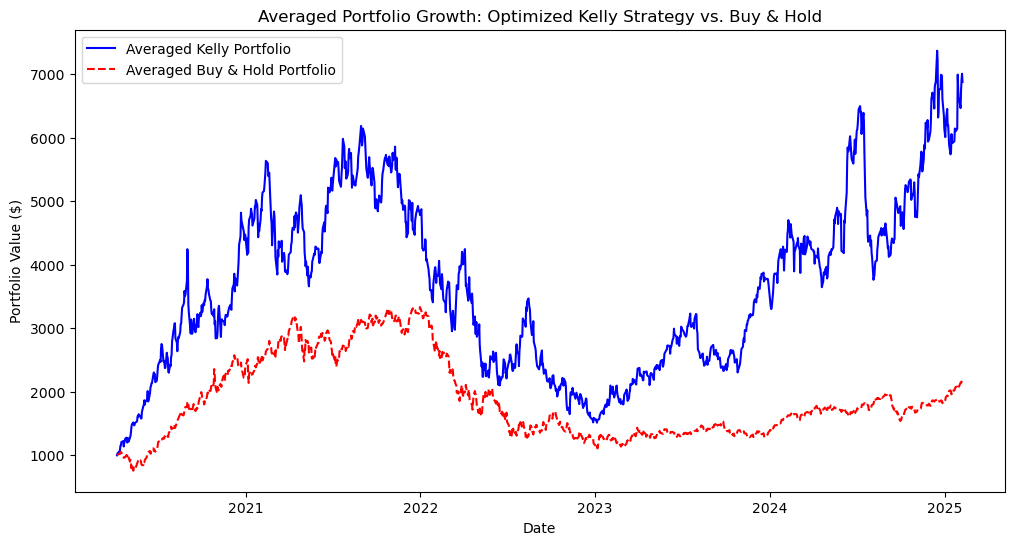

In [139]:
# Set number of trials to run the backtest
num_trials = 2  # Change this to the desired number of trials

# Lists to store results
kelly_sharpe_list = []
kelly_max_drawdown_list = []
kelly_cagr_list = []

buy_hold_sharpe_list = []
buy_hold_max_drawdown_list = []
buy_hold_cagr_list = []

kelly_portfolios = []
buy_hold_portfolios = []

for _ in range(num_trials):
    # Running the final backtest with optimized parameters
    dates, kelly_portfolio = final_portfolio_backtest(test_stocks)
    _, buy_hold_portfolio = portfolio_buy_and_hold(test_stocks)
    dates, kelly_portfolio, buy_hold_portfolio = align_portfolio_lengths(dates, kelly_portfolio, buy_hold_portfolio)

    # Compute risk metrics
    kelly_returns = np.diff(kelly_portfolio) / kelly_portfolio[:-1]
    buy_hold_returns = np.diff(buy_hold_portfolio) / buy_hold_portfolio[:-1]
    num_years = (dates[-1] - dates[0]).days / 365

    kelly_sharpe = calculate_sharpe_ratio(kelly_returns)
    kelly_max_drawdown = calculate_max_drawdown(kelly_portfolio)
    kelly_cagr = calculate_cagr(kelly_portfolio[0], kelly_portfolio[-1], num_years)

    buy_hold_sharpe = calculate_sharpe_ratio(buy_hold_returns)
    buy_hold_max_drawdown = calculate_max_drawdown(buy_hold_portfolio)
    buy_hold_cagr = calculate_cagr(buy_hold_portfolio[0], buy_hold_portfolio[-1], num_years)

    # Store results
    kelly_sharpe_list.append(kelly_sharpe)
    kelly_max_drawdown_list.append(kelly_max_drawdown)
    kelly_cagr_list.append(kelly_cagr)

    buy_hold_sharpe_list.append(buy_hold_sharpe)
    buy_hold_max_drawdown_list.append(buy_hold_max_drawdown)
    buy_hold_cagr_list.append(buy_hold_cagr)

    kelly_portfolios.append(kelly_portfolio)
    buy_hold_portfolios.append(buy_hold_portfolio)

# Compute average risk metrics
avg_kelly_sharpe = np.mean(kelly_sharpe_list)
avg_kelly_max_drawdown = np.mean(kelly_max_drawdown_list)
avg_kelly_cagr = np.mean(kelly_cagr_list)

avg_buy_hold_sharpe = np.mean(buy_hold_sharpe_list)
avg_buy_hold_max_drawdown = np.mean(buy_hold_max_drawdown_list)
avg_buy_hold_cagr = np.mean(buy_hold_cagr_list)

# Compute average bankroll growth over time
kelly_avg_portfolio = np.mean(kelly_portfolios, axis=0)
buy_hold_avg_portfolio = np.mean(buy_hold_portfolios, axis=0)

# Print averaged risk metrics
print(f"AVERAGED Kelly Strategy Performance:\n Sharpe Ratio: {avg_kelly_sharpe:.4f}\n Max Drawdown: {avg_kelly_max_drawdown:.4%}\n CAGR: {avg_kelly_cagr:.4%}")
print(f"AVERAGED Buy & Hold Performance:\n Sharpe Ratio: {avg_buy_hold_sharpe:.4f}\n Max Drawdown: {avg_buy_hold_max_drawdown:.4%}\n CAGR: {avg_buy_hold_cagr:.4%}")

# Plot final averaged results
def plot_final_results(dates, kelly_values, buy_hold_values):
    plt.figure(figsize=(12,6))
    plt.plot(dates, kelly_values, label="Averaged Kelly Portfolio", color="blue")
    plt.plot(dates, buy_hold_values, label="Averaged Buy & Hold Portfolio", color="red", linestyle="dashed")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.title("Averaged Portfolio Growth: Optimized Kelly Strategy vs. Buy & Hold")
    plt.legend()
    plt.show()

# Display final averaged results
plot_final_results(dates, kelly_avg_portfolio, buy_hold_avg_portfolio)

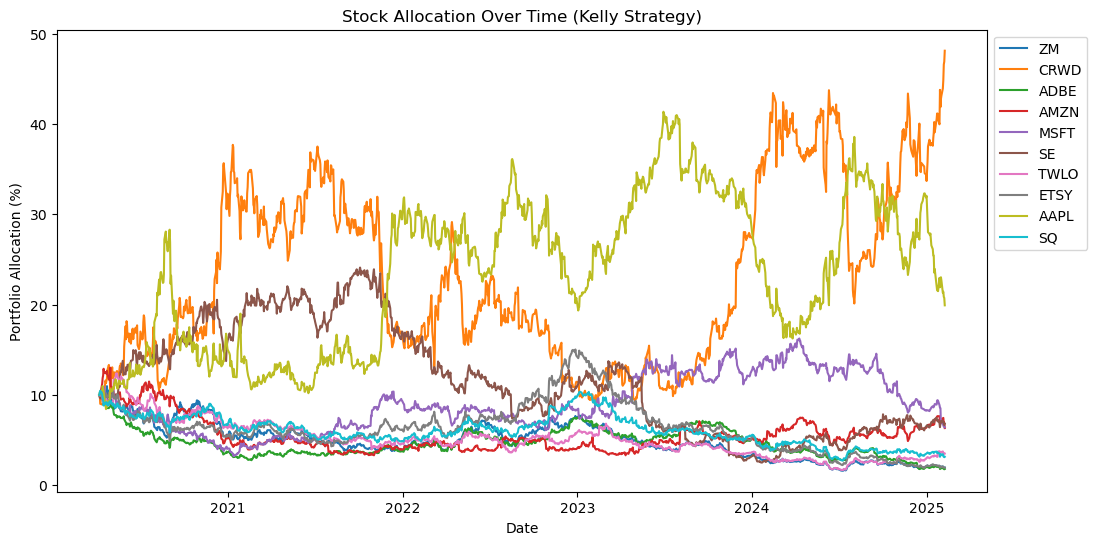

In [141]:
# Function to run the final portfolio backtest and track allocations
def final_portfolio_backtest_with_allocations(stocks, initial_capital=1000):
    capital_per_stock = initial_capital / len(stocks)
    portfolio_bankroll = []
    portfolio_allocations = {}
    dates_list = []
    
    for ticker in stocks:
        stock_data = get_stock_data(ticker)
        if stock_data is None:
            continue
        
        stock_data = detect_market_regime(stock_data, 10, 40)
        stock_data = compute_kelly_fraction(stock_data)
        final_capital_kelly, stock_data = backtest_strategy(stock_data, capital_per_stock)

        if len(stock_data) > 0:
            dates_list.append(stock_data.index)
            portfolio_bankroll.append(stock_data["Bankroll"].values[:len(stock_data.index)])
            portfolio_allocations[ticker] = stock_data["Bankroll"].values[:len(stock_data.index)]

    min_len = min(map(len, portfolio_bankroll))
    portfolio_bankroll = [bankroll[:min_len] for bankroll in portfolio_bankroll]
    dates = dates_list[0][:min_len]
    
    # Sum total portfolio bankroll at each time step
    total_portfolio_bankroll = np.sum(np.array(portfolio_bankroll), axis=0)
    
    # Normalize allocations to get percentages
    for ticker in portfolio_allocations.keys():
        portfolio_allocations[ticker] = portfolio_allocations[ticker][:min_len] / total_portfolio_bankroll
    
    return dates, portfolio_allocations

# Run the single iteration with allocation tracking
dates, allocation_data = final_portfolio_backtest_with_allocations(test_stocks)

# Plot allocation over time
def plot_allocation_over_time(dates, allocation_data):
    plt.figure(figsize=(12, 6))
    for ticker, allocation in allocation_data.items():
        plt.plot(dates, allocation * 100, label=ticker)  # Convert to percentage

    plt.xlabel("Date")
    plt.ylabel("Portfolio Allocation (%)")
    plt.title("Stock Allocation Over Time (Kelly Strategy)")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.show()

# Display allocation chart
plot_allocation_over_time(dates, allocation_data)
